이 코드는 과거에 작성했었던 프로젝트의 코드의 구조를 기억하기 위해 해당 코드를 재구성 한 것입니다.  
참고로 임시파일(testdata.csv)는 라이브러리 임포트 후에 맨 밑에 있는 코드에서 만들 수 있습니다.  
2021/12/28 by skz1024

# 1. 라이브러리 임포트

In [ ]:
import torch # 파이토치: 인공지능 라이브러리
import numpy as np # 넘파이: 수학 관련 라이브러리
import pandas as pd # 판다스: 데이터프레임
import matplotlib.pyplot as plt # 매트플롯립: 시각화

# 2. 판다스를 사용한 데이터 불러오기

In [ ]:
# 판다스를 통한 데이터 불러오기. 파일은 csv를 사용했습니다.
# read_csv('파일 경로')
newDataFrame = pd.read_csv('testdata.csv')

# 3. 커스텀 데이터셋과 커스텀 데이터로더

In [ ]:
# 커스텀 데이터셋은 torch.utils.data.Dataset 클래스를 상속받아서 만듭니다.
# 그리고 3개의 함수를 구현해야 합니다. __init__, __len__, __getitem__
# __init__(self): 이 함수는 객체가 생성될 때 한번만 실행되며 여기서 데이터에 대한 초기화 작업을 합니다.
# __len__(self): 이 함수는 데이터셋의 길이를 알려주는 함수입니다. 해당 데이터셋(배열)의 길이를 리턴하면 됩니다.
# __getitem__(self, index): 이 함수는 데이터셋의 index의 값에 해당하는 데이터를 리턴합니다.
class CustomDataset(torch.utils.data.Dataset):
  def __init__(self):
    self.data = newDataFrame.to_numpy('float32')
  
  def __len__(self):
    return len(self.data)
  
  def __getitem__(self, index):
    return self.data[index]

customDataset = CustomDataset()

In [ ]:
# 데이터로더 사용하기, 커스텀 데이터셋을 데이터로더에 넣습니다.
from torch.utils.data import DataLoader
customDataLoader = DataLoader(customDataset)

# 4. 오토인코더 클래스 만들기 (파이토치 신경망 모델)

In [ ]:
# 파이토치의 신경망 모델은 torch.nn.Module 클래스를 상속받아서 만듭니다.
class AutoEncoder(torch.nn.Module):
  def __init__(self):
    # 참고로 상위객체의 __init__를 호출하지 않을경우 AttributeError가 발생합니다.
    super().__init__()

    # 이 __init__ 함수에 인코더 및 디코더의 구조를 구현합니다.
    # 오토인코더의 원리에 따라 인코딩 과정에서는 데이터의 구조를 압축하고
    # 디코딩 과정에서는 인코딩 과정을 반대로 진행하여 원래 형태로 복원합니다.
    # 코드 구상은 대략적으로 이런 형태입니다.
    # torch.nn.Sequential 모델은 다중 계층을 한 변수에 넣을 수 있습니다.
    self.encoder = torch.nn.Sequential(
      torch.nn.Linear(3, 2),
      torch.nn.Linear(2, 1),
      torch.nn.Linear(1, 1)
    )
    self.decoder = torch.nn.Sequential(
      torch.nn.Linear(1, 1),
      torch.nn.Linear(1, 2),
      torch.nn.Linear(2, 3)
    )

    # 참고사항:
    # 디코딩 된 결과를 torch.nn.Sigmoid나 torch.nn.Softmax를 이용해서 
    # 0 ~ 1사이의 값으로 변환해야 할 수도 있습니다.

  def forward(self, data):
    # forward 함수에서는 해당 오토인코더 클래스를 사용한 결과를 리턴합니다.
    # 먼저 torch.nn.Flatten 함수를 사용하여 배열을 1차원화 한 다음
    # 해당 데이터를 encoder를 사용해 인코딩 한 다음
    # 인코딩 된 데이터를 decoder를 사용해 디코딩 합니다.
    # 디코딩 된 결과를 리턴합니다.
    # flattenData = torch.nn.Flatten(data)
    flattenData = data
    encoderData = self.encoder(flattenData)
    decoderData = self.decoder(encoderData)
    return decoderData

autoEncoder = AutoEncoder()

In [ ]:
epochs = 10 # 에폭 수
loss_function = torch.nn.MSELoss() # 손실 함수 설정
optimizer = torch.optim.Adam(autoEncoder.parameters()) # 옵티마이저 설정

for i in range(epochs): # 에폭 수 만큼 반복을 진행합니다.
  for j, data in enumerate(customDataLoader): # 그 후 데이터로더를 이용해 반복문을 만듭니다.
    result = autoEncoder(data) # 데이터를 오토인코더에 집어넣습니다. 그 결과를 result 변수에 저장합니다.
    loss = loss_function(result, data) # 원본데이터와 결과데이터를 비교하여 손실값을 계산합니다.

    # 그 후 다음과 같은 과정을 사용
    optimizer.zero_grad() # 가중치 초기화
    loss.backward() # 역전파 계산
    optimizer.step() # 다음 스텝으로

  # 에폭이 끝난경우 손실값과 같이 출력
  print('epoch:', i, ', loss:', loss)


epoch: 0 , loss: tensor(6.4108, grad_fn=<MseLossBackward0>)
epoch: 1 , loss: tensor(6.2907, grad_fn=<MseLossBackward0>)
epoch: 2 , loss: tensor(6.1044, grad_fn=<MseLossBackward0>)
epoch: 3 , loss: tensor(5.9538, grad_fn=<MseLossBackward0>)
epoch: 4 , loss: tensor(5.8735, grad_fn=<MseLossBackward0>)
epoch: 5 , loss: tensor(5.6870, grad_fn=<MseLossBackward0>)
epoch: 6 , loss: tensor(5.5678, grad_fn=<MseLossBackward0>)
epoch: 7 , loss: tensor(5.4436, grad_fn=<MseLossBackward0>)
epoch: 8 , loss: tensor(5.3814, grad_fn=<MseLossBackward0>)
epoch: 9 , loss: tensor(5.2960, grad_fn=<MseLossBackward0>)


In [ ]:
totalDataFrame = pd.DataFrame(columns=['lv', 'attack', 'clear'])
totalDataFrameResult = pd.DataFrame(columns=['lv', 'attack', 'clear'])
totalData = []
totalResult = []

# 학습이 완료되었다면, data를 데이터로더를 이용해 불러오고
# 새로운 데이터로 재 가공한 뒤 원본과 얼마나 차이나는지 알아봅시다.
# 학습 과정이 아니기 때문에 손실 함수와 미분 계산은 사용하지 않습니다.
for j, data in enumerate(customDataLoader): # 데이터로더에 있는 데이터를 반복문을 이용해 불러옵니다.
  result = autoEncoder(data) # 오토인코더에 데이터를 넣고 그 결과를 변수에 저장

  getData = data.detach().numpy() # 텐서를 넘파이로 변환합니다.
  getResult = result.detach().numpy()

  # 판다스의 데이터프레임에 데이터를 넣기 위해 객체로 변환
  setData = {'lv':getData[0][0], 'attack':getData[0][1], 'clear':getData[0][2]}
  setResult = {'lv':getResult[0][0], 'attack':getResult[0][1], 'clear':getResult[0][2]}
  
  # 배열에다가 데이터 추가 (데이터프레임의 append함수를 여기서 쓰면 계산 시간이 오래 걸립니다.)
  totalData.append(setData)
  totalResult.append(setResult)

# 아까 추가된 데이터 배열을 이용하여 데이터프레임에 추가합니다.
totalDataFrame = totalDataFrame.append(totalData, ignore_index=True)
totalDataFrameResult = totalDataFrameResult.append(totalResult, ignore_index=True)

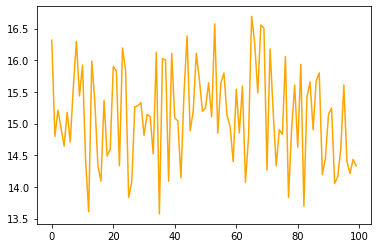

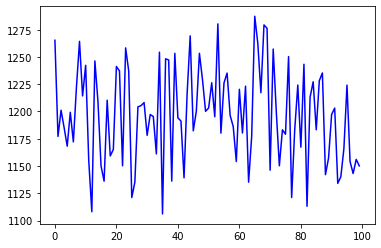

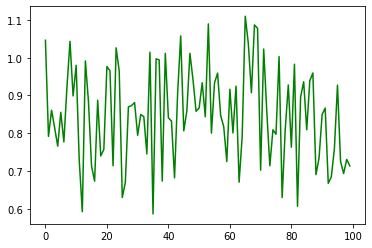

In [ ]:
# plot 을 사용하여 그래프 그리기, 데이터가 많기 때문에 100개만 출력했습니다.
# 기계학습을 하면서 실제 수치의 기울기에 따라 수치가 재조정된걸 알 수 있습니다. 
plt.plot(totalDataFrameResult['lv'][:100], color='orange')
plt.show()
plt.plot(totalDataFrameResult['attack'][:100], color='blue')
plt.show()
plt.plot(totalDataFrameResult['clear'][:100], color='green')
plt.show()

# xx. 실험용 임시 데이터

In [ ]:
import random

lv = []
attack = []
clear = []

for i in range(0, 10000):
  setLevel = random.randint(10, 20)
  lv.append(setLevel)

  setAttack = 1000 + (setLevel * 10) + random.randint(0, 100)
  attack.append(setAttack)

  isClear = 0
  if(setAttack >= 1150):
    isClear = 1
  else:
    isClear = 0
  
  clear.append(isClear)

# 실험용 임시데이터를 데이터프레임으로 만들고 csv파일로 저장
a = {'lv':lv, 'attack':attack, 'clear':clear}
newDataFrame = pd.DataFrame(a)
newDataFrame.to_csv('testdata.csv', index=False)